In [2]:
import os
import sys
from tweepy import API
from tweepy import OAuthHandler
from tweepy import Cursor
import json
from collections import Counter
import math
import time
import pandas as pd
import csv
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

In [5]:
def getTwitterOAuth():
    consumer_key = ''
    consumer_secret = ''
    access_token = ''
    access_token_secret = ''
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token,access_token_secret)
    return auth

def TwitterClient():
    auth = getTwitterOAuth()
    client = API(auth)
    return client

#global variables
MAX_FRIENDS = 15000
max_pages = math.ceil(MAX_FRIENDS/5000)
        

In [6]:
def paginate(items,n):
    for i in range(0, len(items),n):
        yield items[i:i+n] 

In [7]:
usrSet = set()
usrSet2 = set()


In [8]:
# user friends
usrset3 = set()

def userFriends(user="AvokaAyebilla"):
    client = TwitterClient()
    fname = "{}_friends.jsonl".format(user)
    with open(fname, 'w') as f:
        for friends in Cursor(client.friends_ids,screen_name=user).pages(max_pages):
            for chunk in paginate(friends, 100):
                users = client.lookup_users(user_ids=chunk)
                for usr in users:
                    if usr.location =='Ghana':
                        usrset3.add(usr.screen_name)
                        f.write(json.dumps(usr._json)+"\n")
            if len(friends) == 300:
                print("More results available. Sleeping for 1 minute to avoid rate limit..")
                time.sleep(120)
    #return usrSet2

In [9]:
def getUserTweets(user='AvokaAyebilla'):
    client = TwitterClient()
    fname = "user_timeline_{}.jsonl".format(user)
    with open(fname, 'w') as f:
        for page in Cursor(client.user_timeline, screen_name=user,count=200).pages(2):
            for status in page:
                f.write(json.dumps(status._json) + "\n")


def getHashtags(tweet):
    entities = tweet.get('entities',{})
    hashtags = entities.get('hashtags',[])
    return [tag['text'].lower() for tag in hashtags]
def tags(user='AvokaAyebilla', dictTags = {}): #dicTags is a dictionary containing the keywords as keys and 
                                                #the hashtags of interest as a list of values
    stats = {'economy': 0, 'social':0, 'culture': 0,'health':0}
    labels = ['economy','social','culture','health']                                                          #set all feature count to zeros.
    fname = "user_timeline_{}.jsonl".format(user)
    with open(fname, 'r') as f:
        hashtags = [] #Counter()
        for line in f:
            tweet = json.loads(line)
            tags_in_tweet = getHashtags(tweet)
            if len(tags_in_tweet)>0:
                hashtags.append(tags_in_tweet)
        for tag in hashtags:
            for tt in tag:
                for key in labels:
                    if tt in dictTags[key]:
                        stats[key] =stats[key] + 1 
    #print(hashtags)
    return {user: list(stats.values())}
                    


Following are list of some identified top Ghanaians in different industries 
identified. Their twitter handles were obtained by searching their names on twitter
We then get their friends and add it to form the top 1000 Ghanaians on twitter.
Repeaton was disallowed by using the python set.


In [10]:

uList = []
htags = {'economy': ['yearofreturn','ghanaianbusiness','localbusiness',
                     'ghanabeyondaid','2020budgetreview',
                     'sdgs','beyondthelockdown','farmersdayghana'], 
         'social':['ghtourism','ghweddings','imwithher','tadigirls',
                   'justiceforgeorgefloyd','girlchildeducation',
                   'lutterodt','hushpuppi','ugandavsghana'], 
         'culture': ['independenceday','ghanamostbeautiful','ghana',
                     'saynotocorruption', 'goodmorningremix','gmb2020',
                     'nsmq','registertovote2020', 'mokobe'],
         'health':['stayhome','socialdistancing','spreadcalmnotfear',
                   'ghanacovid19','wearyourmask','covid19','ghhealth',
                   'globalhealth','staysafe']}

with open('Top_ghanaians_usrs.csv', 'rt') as f:
        f.readline()
        csv_reader = csv.reader(f)
        for line in csv_reader:
            if os.path.exists("user_timeline_{}.jsonl".format(line[0])):
                try:
                    uList.append(tags(line[0], htags))
                except Exception as e:
                    print( "Error while getting hashtags for  {}".format(line[0]))
                    print(e)
                

'''Output from calling the tags function is a dictionary with the user specified as the key and the 
four parameters as the a list value. In order to call this function manytimes for the many users we have,
use a list or a dictionary to record every return of the function. In this case, a list is used. Manipulate this 
list of dictionary to get the output into a list for easy conversion to a pandas dataframe. You can do it
differently but here how I did it with the functions below. note that, this written with the assumption that
the data exist on your disk. If you don't have the data, you will first run the getUserTweets() method to 
download the timelines of the users you need. 
'''
#prepare a data frame
def get_dictkeys(listdic):
    return list(listdic.keys())

#returns the values of the dictionary as a list
def get_dictvals(listdic):
     return list(listdic.values())

def dataframe():
    keysList = []
    valList = []
    data = []
    fkeyList = []
    for item in uList:
        keysList.append(get_dictkeys(item))
        valList.append(get_dictvals(item))
    for it in valList:
        data.append(it[0])
    for n in keysList:
        fkeyList.append(n[0])  
    df = pd.DataFrame(data, columns = ["economy", "social","culture","health"])
    df.insert(0,'user',fkeyList)
    return df


In [216]:
dff = dataframe()
dff.to_csv('ghanadata.csv', sep=',', index =False, encoding='utf-8')
dff.head(10)


,user,economy,social,culture,health
0,sambahflex,0,0,1,0
1,CoOwusu,0,0,0,0
2,AshesiIX,0,0,0,0
3,askrashida,0,0,0,0
4,Ghanasoccernet,0,0,0,0
5,TransformingGh,0,0,29,0
6,KelOwusu,0,0,8,6
7,fellowblackman,0,0,2,0
8,kkdbod,1,0,2,1
9,talentshype,0,0,0,0


In [206]:
X = dff.iloc[:,1:5]
kmeans = KMeans(4)
#kmeans.fit(X)

In [207]:
identified_cluster = kmeans.fit_predict(X)
identified_cluster

array([0, 0, 0, ..., 0, 0, 0])

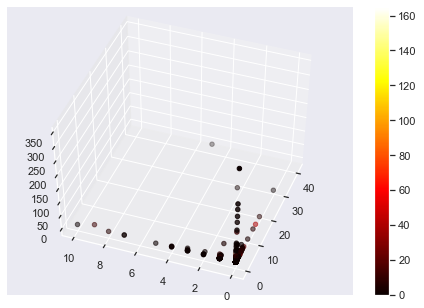

In [214]:
from mpl_toolkits.mplot3d import Axes3D
data_wt_clusters = dff.copy()
data_wt_clusters['clusters'] = identified_cluster
fig =plt.figure()
#ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
#ax = fig.add_subplot(111,projection='3d')
ax = Axes3D(fig, rect=[1, 1, 1, 1], elev=48, azim=200)

x = data_wt_clusters['economy']
y = data_wt_clusters['social']
z = data_wt_clusters['culture']
c = data_wt_clusters['health']

img = ax.scatter(x,y,z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()


Processing the data required many discrete step that required hard-coding at some points. The functions below were used to process the lists of friends to store them into a csv file as one. Once we have the complete csv file of uses, we really don't these functions anymore. I have left just in case I want to extend my input then I may just come back to them again. The major thing is to read and understand the key helper functions above and know what they return. You then decide how you want to manipulate the results returned to you. You also want to understand the input and consider the time it takes to fetch the data you want from twitter. with this in mind, you can run this code step by step to get the desired results.

In [ ]:

handset1 = set()
handset2 = set()
handset3 = set()

In [227]:

handles = []
def readfile():
    with open('Top_ghanaians.csv', 'rt') as f:
        f.readline()
        csv_reader = csv.reader(f)
        for line in csv_reader:
            handles.append(line)         
readfile()           

In [228]:
for i in handles:
    for j in i:
        handset1.add(j)
#handset2




In [246]:
handset4 = set()
userList = useList + list3 + list2
for i in userList:
    handset4.add(i)


In [250]:
usrhandles = set.union(handset1, handset2, handset3,handset4)
df = pd.DataFrame(usrhandles, columns = ['user_handles'])
df.to_csv('Top_ghanaians_usrs.csv', sep=',', index =False, encoding='utf-8')